In [1]:
# Import libraries needed for the analysis
import os
import pandas as pd
import numpy as np

from datetime import datetime
import random
import string

import tensorflow as tf
from tensorflow import keras
from keras.optimizers import Adam
import keras.backend as K

import matplotlib.pyplot as plt
import seaborn as sns

import re
import nltk

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
def recall_m(y_true, y_pred):
    """
    Recall is the number of relevant documents retrieved by a search
    divided by
    the total number of existing relevant documents;
    
    True & predicted positives divided by Total True positives
                                (regardless of what was predicted);
    
    The True Positive Rate.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    """
    Precision is number of relevant documents retrieved by a search
    divided by
    the total number of documents retrieved by that search.
    
    True Positives / Predicted Positives
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [3]:
# seed value for random number generators to obtain reproducible results
RANDOM_SEED = 5
from numpy.random import seed
seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)
dims = 200

In [4]:
# Read the training and test datasets
train_tweets = pd.read_csv("/Users/kerry//Projects/grad_school_portfolio/Fall2020/MSDS422/rnn/data/train.csv")
test_tweets = pd.read_csv("/Users/kerry//Projects/grad_school_portfolio/Fall2020/MSDS422/rnn/data/test.csv")
#train_tweets= pd.read_csv('/Users/harini-mac/Desktop/Northwestern University/MSDS-422/Week8/project1/nlp-getting-started/train.csv')
#test_tweets=pd.read_csv('/Users/harini-mac/Desktop/Northwestern University/MSDS-422/Week8/project1/nlp-getting-started/test.csv')

In [5]:
train_tweets.shape

(7613, 5)

In [6]:
test_tweets.shape

(3263, 4)

In [7]:
train_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [8]:
test_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


In [9]:
train_tweets.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [10]:
# drops dups (retweets)
train_tweets[train_tweets.duplicated(subset="text", keep='first')==False]

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7604,10863,NaN,NaN,#WorldNews Fallen powerlines on G:link tram: U...,1
7605,10864,NaN,NaN,on the flip side I'm at Walmart and there is a...,1
7606,10866,NaN,NaN,Suicide bomber kills 15 in Saudi security site...,1
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1


In [11]:
# drops ~ 5-10 records most of which I find misclassified
train_tweets[(train_tweets.keyword=="blaze") & (train_tweets.target==1)]

,id,keyword,location,text,target
647,938,blaze,"Temecula, CA",Pendleton media office said only fire on base ...,1
649,940,blaze,"Fresno, CA",Love living on my own. I can blaze inside my a...,1
653,945,blaze,Australia,Property losses from California wildfire nearl...,1
654,946,blaze,"Raleigh Durham, NC",#breaking Firefighters battling blaze at east ...,1
669,964,blaze,Karachi,Property losses from #California wildfire near...,1


In [12]:
#Create a dataframe to store the model accuracy and scores
results_tbl = pd.DataFrame(columns=['Model_name','vocabulary size (factor1)', 'pre-trained vector (factor2)','RNN structure (factor3)','hyperparameter recurrent_dropout (factor4)','Processing Time','Training Set Accuracy','Validation Set Accuracy','train f1','validation f1','Test Set F1-score (Kaggle score)'])
results_tbl.info()

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 11 columns):
 #   Column                                      Non-Null Count  Dtype 
---  ------                                      --------------  ----- 
 0   Model_name                                  0 non-null      object
 1   vocabulary size (factor1)                   0 non-null      object
 2   pre-trained vector (factor2)                0 non-null      object
 3   RNN structure (factor3)                     0 non-null      object
 4   hyperparameter recurrent_dropout (factor4)  0 non-null      object
 5   Processing Time                             0 non-null      object
 6   Training Set Accuracy                       0 non-null      object
 7   Validation Set Accuracy                     0 non-null      object
 8   train f1                                    0 non-null      object
 9   validation f1                               0 non-null      object
 10  Test Set F1-score (Kaggle score)           

# Exploratory Data Analysis & Data Preparation

Text(0.5, 1.0, 'target count plot in the training data (0 - not a real disaster, 1 - a real disaster)')

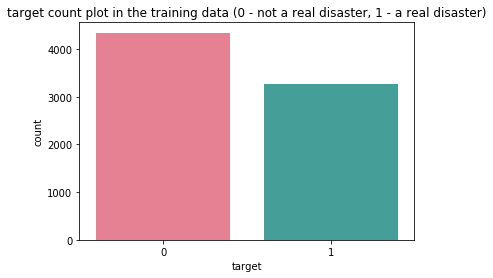

In [13]:
# Count plot of the targets in training data 
sns.countplot(train_tweets['target'], palette="husl")
plt.title('target count plot in the training data (0 - not a real disaster, 1 - a real disaster)')

In [14]:
# check for any null values 
# the variable of interest in the data is text.
train_tweets.isna().sum() 

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

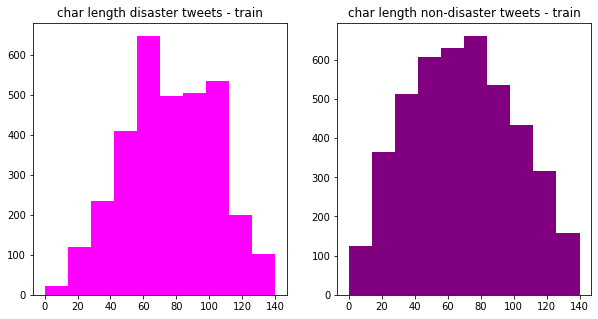

In [49]:
# Distribution of the length of the tweets in the training data
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
disaster_tweets_len = train_tweets[train_tweets['target']==1]['text'].str.len()
nondisaster_tweets_len = train_tweets[train_tweets['target']==0]['text'].str.len()
ax1.hist(disaster_tweets_len, color="magenta")
ax1.set_title('char length disaster tweets - train')
ax2.hist(nondisaster_tweets_len, color="purple")
ax2.set_title('char length non-disaster tweets - train')
plt.show()

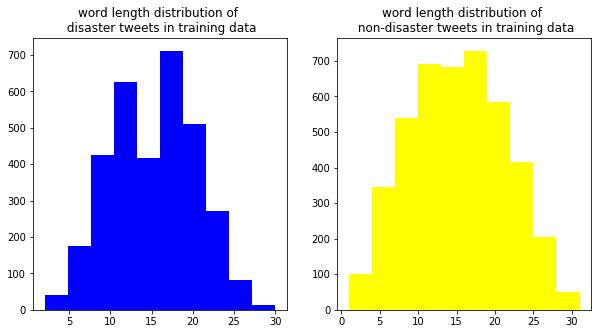

In [16]:
# Distribution of the word lengths of the tweets in the  training data
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
diaster_tweet_lengths=train_tweets[train_tweets['target']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(diaster_tweet_lengths,color='blue')
ax1.set_title('word length distribution of \n disaster tweets in training data')
nondisaster_tweet_lengths=train_tweets[train_tweets['target']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(nondisaster_tweet_lengths,color='yellow')
ax2.set_title('word length distribution of \n non-disaster tweets in training data')
plt.show()

# Read function for the  GloVe (global vectors) 

In [17]:
#reading from the file to turn the words to word embedding vector
def read_glove_vecs(glove_file):
    with open(glove_file, 'r') as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
        
        i = 1
        words_to_index = {}
        index_to_words = {}
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
    return words_to_index, index_to_words, word_to_vec_map

## Read the Glove file - glove.6B.200d.txt

In [18]:
#reading from the file to learn the word embedding into the list word_to_vec_map
#word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('/Users/harini-mac/Desktop/Northwestern University/MSDS-422/Week8/project1/nlp-getting-started/embeddings/gloVe.6B/glove.6B.50d.txt')
#word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('/Users/kerry/Downloads/embeddings/gloVe.6B/glove.6B.50d.txt')

In [19]:
#reading from the file to learn the word embedding into the list word_to_vec_map
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('/Users/kerry/Downloads/embeddings/gloVe.6B/glove.6B.200d.txt')

In [20]:
len(word_to_index)

400000

In [21]:
len(word_to_vec_map)

400000

In [22]:
len(index_to_word)

400000

## Cleanse the training and test data 
## Use the word_to_vec_map from glove.6B.50d

In [23]:
def clean(text):
#    rgx_fix_caps = "(?<=[\.!?]\s)([A-Z])" # fixes like Hello into hello???
#    subst = r"\\"
#    pre_sentence = re.sub(rgx_fix_caps, subst, text)
    
    rgx_rmv_punc = re.compile('([^\s\w]|_)+') # removes punctuation
    sentence = rgx_rmv_punc.sub("", text).lower()
    
    sentence = sentence.split(" ")
    
    for word in list(sentence):
        if word not in word_to_vec_map: # removes word if it's not in the 'dictionary' (txt file). case-sensitive.
            sentence.remove(word)
            
    sentence = " ".join(sentence)
    return sentence

In [24]:
clean(train_tweets.loc[2,'text'])

'all residents asked to shelter in place are being notified by officers no other evacuation or shelter in place orders are expected'

In [25]:
for i in range (train_tweets.shape[0]):
    train_tweets.at[i,'text']=clean(train_tweets.loc[i,'text'])
    
for i in range(test_tweets.shape[0]):
    test_tweets.at[i,'text']=clean(test_tweets.loc[i,'text'])

In [26]:
train_text = train_tweets['text']
test_text = test_tweets['text']

# Encode the text in the training data
# Pad the resultant sequences

In [27]:
# https://stackoverflow.com/questions/57693333/processing-before-or-after-train-test-split
# https://www.kdnuggets.com/2020/03/tensorflow-keras-tokenization-text-data-prep.html
tokenizer = keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(train_text)

In [28]:
train_sequences = tokenizer.texts_to_sequences(train_text)

In [29]:
tokenizer.texts_to_sequences(["Forest fire near La Ronge Sask. Canada"])

[[178, 42, 214, 664, 6037, 6038, 1319]]

In [30]:
tokenizer.sequences_to_texts([[178, 42, 214, 664, 6037, 6038, 1319]])

['forest fire near la ronge sask canada']

In [31]:
word2index = tokenizer.word_index
print("Number of unique tokens : ",len(word2index))

Number of unique tokens :  12256


In [32]:
dataset_size = tokenizer.document_count
dataset_size

7613

In [33]:
# Get max training sequence length
maxlen = max([len(x) for x in train_sequences])
maxlen

31

In [34]:
padded_seq = keras.preprocessing.sequence.pad_sequences(train_sequences,maxlen)
X_train = padded_seq
Y_train = train_tweets['target']
X_train.shape

(7613, 31)

# Generate embedding matrix for tokens in the training data - 200 Dimensions

In [35]:
embedding_matrix = np.zeros((len(word2index)+1, dims))

embedding_vec=[]
for word, i in word2index.items():
    embedding_vec = word_to_vec_map.get(word)
    if embedding_vec is not None:
        embedding_matrix[i] = embedding_vec

In [36]:
print(embedding_matrix[1])

[-7.1549e-02  9.3459e-02  2.3738e-02 -9.0339e-02  5.6123e-02  3.2547e-01
 -3.9796e-01 -9.2139e-02  6.1181e-02 -1.8950e-01  1.3061e-01  1.4349e-01
  1.1479e-02  3.8158e-01  5.4030e-01 -1.4088e-01  2.4315e-01  2.3036e-01
 -5.5339e-01  4.8154e-02  4.5662e-01  3.2338e+00  2.0199e-02  4.9019e-02
 -1.4132e-02  7.6017e-02 -1.1527e-01  2.0060e-01 -7.7657e-02  2.4328e-01
  1.6368e-01 -3.4118e-01 -6.6070e-02  1.0152e-01  3.8232e-02 -1.7668e-01
 -8.8153e-01 -3.3895e-01 -3.5481e-02 -5.5095e-01 -1.6899e-02 -4.3982e-01
  3.9004e-02  4.0447e-01 -2.5880e-01  6.4594e-01  2.6641e-01  2.8009e-01
 -2.4625e-02  6.3302e-01 -3.1700e-01  1.0271e-01  3.0886e-01  9.7792e-02
 -3.8227e-01  8.6552e-02  4.7075e-02  2.3511e-01 -3.2127e-01 -2.8538e-01
  1.6670e-01 -4.9707e-03 -6.2714e-01 -2.4904e-01  2.9713e-01  1.4379e-01
 -1.2325e-01 -5.8178e-02 -1.0290e-03 -8.2126e-02  3.6935e-01 -5.8442e-04
  3.4286e-01  2.8426e-01 -6.8599e-02  6.5747e-01 -2.9087e-02  1.6184e-01
  7.3672e-02 -3.0343e-01  9.5733e-02 -5.2860e-01 -2

In [37]:
print(embedding_matrix.shape)

(12257, 200)


# Prepare the test data

In [61]:
test_sequences = tokenizer.texts_to_sequences(test_text)
padded_seq = keras.preprocessing.sequence.pad_sequences(test_sequences,maxlen)
X_test = padded_seq
X_test.shape

(3263, 31)

# Fit RNN 1
# vocabulary size (factor 1): 400K
# pre-trained vector (factor 2): GloVe.6B.50d
# rnn structure (factor 3): LSTM layer based structure
# recurrent dropout (factor 4): 0.1

In [50]:
model1 = keras.models.Sequential([
    keras.layers.Embedding(len(word2index)+1,
                           dims,
                           weights=[embedding_matrix],
                           input_length=maxlen,
                           trainable=True),
    keras.layers.LSTM(units=128, return_sequences = True, recurrent_dropout = 0.25, dropout = 0.25),
    keras.layers.LSTM(units=64, recurrent_dropout = 0.25, dropout = 0.25),
    keras.layers.Dense(32, activation='tanh'),
    keras.layers.Dense(4, activation='tanh')
])

In [51]:
model1.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 31, 200)           2451400   
_________________________________________________________________
lstm_6 (LSTM)                (None, 31, 128)           168448    
_________________________________________________________________
lstm_7 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_6 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_7 (Dense)              (None, 4)                 132       
Total params: 2,671,468
Trainable params: 2,671,468
Non-trainable params: 0
_________________________________________________________________


In [52]:
opt=Adam(learning_rate=1e-5)
model1.compile(
  loss='binary_crossentropy',
  optimizer=opt,
  metrics=['accuracy', f1_m],
)

In [53]:
# Fit the model; obtain the model fit time
start=datetime.now()
history1 = model1.fit(X_train,Y_train,
                    batch_size=32,
                    epochs=30,
                    validation_split=0.3
)
end=datetime.now()
print(end-start)

Epoch 1/30
167/167 [==============================] - 31s 186ms/step - loss: 2.6741 - accuracy: 0.0779 - f1_m: 0.0012 - val_loss: 2.3991 - val_accuracy: 0.0915 - val_f1_m: 0.0025
Epoch 2/30
167/167 [==============================] - 31s 188ms/step - loss: 2.2469 - accuracy: 0.0959 - f1_m: 0.0247 - val_loss: 2.1913 - val_accuracy: 0.1073 - val_f1_m: 0.0298
Epoch 3/30
167/167 [==============================] - 30s 178ms/step - loss: 1.6461 - accuracy: 0.1137 - f1_m: 0.0818 - val_loss: 1.0301 - val_accuracy: 0.1546 - val_f1_m: 0.0449
Epoch 4/30
167/167 [==============================] - 34s 201ms/step - loss: 0.9686 - accuracy: 0.2102 - f1_m: 0.0558 - val_loss: 0.8815 - val_accuracy: 0.2623 - val_f1_m: 0.0240
Epoch 5/30
167/167 [==============================] - 30s 179ms/step - loss: 0.8964 - accuracy: 0.2447 - f1_m: 0.0520 - val_loss: 0.8643 - val_accuracy: 0.2688 - val_f1_m: 0.0263
Epoch 6/30
167/167 [==============================] - 33s 199ms/step - loss: 0.8985 - accuracy: 0.2441 - 

In [54]:
print ('Best Train Accuracy: ')
best_model_train_accuracy = np.round(history1.history['accuracy'][np.argmin(history1.history['loss'])],4)
best_model_train_accuracy

Best Train Accuracy: 


0.3019

In [55]:
print ('Best Validation Accuracy: ')
best_model_val_accuracy = np.round(history1.history['val_accuracy'][np.argmin(history1.history['val_loss'])],4)
best_model_val_accuracy

Best Validation Accuracy: 


0.3586

In [56]:
best_model_train_f1 = max(np.round(history1.history['f1_m'],4))
print ('Best Train f1: {}'.format(best_model_train_f1))

best_model_val_f1 = max(np.round(history1.history['val_f1_m'],4))
print ('Best val f1: {}'.format(best_model_val_f1))

Best Train f1: 0.7372
Best val f1: 0.6869


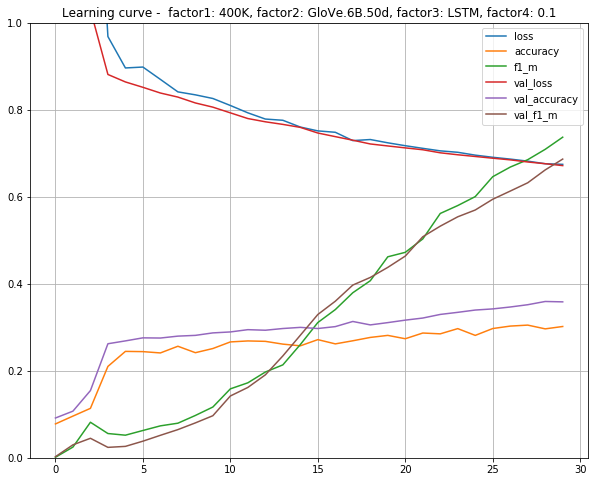

In [57]:
# Plot the learning curve
pd.DataFrame(history1.history).plot(figsize=(10, 8))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.title('Learning curve -  factor1: 400K, factor2: GloVe.6B.50d, factor3: LSTM, factor4: 0.1')
plt.show()

# model 1 predictions (1=distaster tweet)

In [62]:
predict1 = model1.predict_classes(X_test)
predict1

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


array([0, 2, 2, ..., 0, 2, 2])

In [63]:
len(predict1)

3263

In [64]:
# save the results to a csv
submission_df = pd.DataFrame({'id':test_tweets['id'],'target':np.squeeze(predict1)})
submission_df.to_csv('submission_rnn_1.csv',index=False)

In [65]:
#Store the accuracy and kaggle score for this model 
results_tbl = results_tbl.append({'Model_name':'RNN #1', 
                                   'vocabulary size (factor1)':'400K',
                                   'pre-trained vector (factor2)':'GloVe.6B.200d',
                                   'RNN structure (factor3)':'LSTM layer based',
                                   'hyperparameter recurrent_dropout (factor4)': '0.25',
                                   'Processing Time':(end-start),
                                   'Training Set Accuracy':best_model_train_accuracy,
                                   'Validation Set Accuracy':best_model_val_accuracy,
                                   'train f1':best_model_train_f1,
                                   'validation f1':best_model_val_f1,
                                   'Test Set F1-score (Kaggle score)': ''
                                   },ignore_index=True)
results_tbl


,Model_name,vocabulary size (factor1),pre-trained vector (factor2),RNN structure (factor3),hyperparameter recurrent_dropout (factor4),Processing Time,Training Set Accuracy,Validation Set Accuracy,train f1,validation f1,Test Set F1-score (Kaggle score)
0,RNN #1,400K,GloVe.6B.50d,LSTM layer based,0.1,00:14:13.500154,0.3019,0.3586,0.7372,0.6869,0.78087


# Fit RNN 2
# vocabulary size (factor 1): 400K
# pre-trained vector (factor 2): GloVe.6B.200d
# rnn structure (factor 3): LSTM layer based structure
# recurrent dropout (factor 4): 0.3

In [67]:
model2 = keras.models.Sequential([
    keras.layers.Embedding(len(word2index)+1,
                           dims,
                           weights=[embedding_matrix],
                           input_length=maxlen,
                           trainable=False),
    keras.layers.LSTM(units=128 , return_sequences = True , recurrent_dropout = 0.3 , dropout = 0.3),
    keras.layers.LSTM(units=64 , recurrent_dropout = 0.3 , dropout = 0.3),
    keras.layers.Dense(32, activation='tanh'),
    keras.layers.Dense(1, activation='tanh')
])

In [68]:
model2.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 31, 200)           2451400   
_________________________________________________________________
lstm_10 (LSTM)               (None, 31, 128)           168448    
_________________________________________________________________
lstm_11 (LSTM)               (None, 64)                49408     
_________________________________________________________________
dense_10 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 33        
Total params: 2,671,369
Trainable params: 219,969
Non-trainable params: 2,451,400
_________________________________________________________________


In [69]:
opt=Adam(learning_rate=1e-5)
model2.compile(
  loss='binary_crossentropy',
  optimizer=opt,
  metrics=['accuracy', f1_m],
)

In [70]:
# Fit the model; obtain the model fit time
start=datetime.now()
history2 = model2.fit(X_train,Y_train,
                    batch_size=32,
                    epochs=40,
                    validation_split=0.3
)
end=datetime.now()
print(end-start)

Epoch 1/40
167/167 [==============================] - 19s 112ms/step - loss: 1.0962 - accuracy: 0.5757 - f1_m: 0.0348 - val_loss: 0.7957 - val_accuracy: 0.5512 - val_f1_m: 0.0837
Epoch 2/40
167/167 [==============================] - 18s 110ms/step - loss: 0.7681 - accuracy: 0.5729 - f1_m: 0.2133 - val_loss: 0.7318 - val_accuracy: 0.5670 - val_f1_m: 0.2922
Epoch 3/40
167/167 [==============================] - 19s 115ms/step - loss: 0.7337 - accuracy: 0.5759 - f1_m: 0.3368 - val_loss: 0.7020 - val_accuracy: 0.5827 - val_f1_m: 0.3858
Epoch 4/40
167/167 [==============================] - 20s 119ms/step - loss: 0.6999 - accuracy: 0.5894 - f1_m: 0.3850 - val_loss: 0.6863 - val_accuracy: 0.5928 - val_f1_m: 0.4103
Epoch 5/40
167/167 [==============================] - 20s 122ms/step - loss: 0.6821 - accuracy: 0.6042 - f1_m: 0.4357 - val_loss: 0.6736 - val_accuracy: 0.6151 - val_f1_m: 0.4461
Epoch 6/40
167/167 [==============================] - 21s 123ms/step - loss: 0.6649 - accuracy: 0.6223 - 

In [71]:
print ('Best Train Accuracy: ')
best_model_train_accuracy = np.round(history2.history['accuracy'][np.argmin(history2.history['loss'])],4)
best_model_train_accuracy

Best Train Accuracy: 


0.7703

In [72]:
print ('Best Validation Accuracy: ')
best_model_val_accuracy = np.round(history2.history['val_accuracy'][np.argmin(history2.history['val_loss'])],4)
best_model_val_accuracy

Best Validation Accuracy: 


0.7754

In [73]:
best_model_train_f1 = max(np.round(history2.history['f1_m'],4))
print ('Best Train f1: {}'.format(best_model_train_f1))

best_model_val_f1 = max(np.round(history2.history['val_f1_m'],4))
print ('Best val f1: {}'.format(best_model_val_f1))

Best Train f1: 0.7116
Best val f1: 0.6222


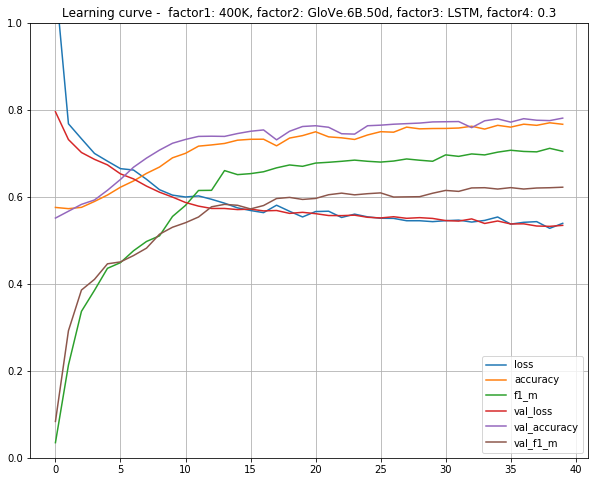

In [74]:
# Plot the learning curve
pd.DataFrame(history2.history).plot(figsize=(10, 8))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.title('Learning curve -  factor1: 400K, factor2: GloVe.6B.50d, factor3: LSTM, factor4: 0.3')
plt.show()

# model 2 predictions (1=disaster tweet)

In [75]:
predict2 = model2.predict_classes(X_test)
predict2

array([[1],
       [1],
       [1],
       ...,
       [0],
       [0],
       [1]], dtype=int32)

In [76]:
len(predict2)

3263

In [77]:
# save the results to a csv
submission_df = pd.DataFrame({'id':test_tweets['id'],'target':np.squeeze(predict2)})
submission_df.to_csv('submission_rnn_2.csv',index=False)

In [78]:
#Store the accuracy and kaggle score for this model 
results_tbl = results_tbl.append({'Model_name':'RNN #2', 
                                   'vocabulary size (factor1)':'400K',
                                   'pre-trained vector (factor2)':'GloVe.6B.200d',
                                   'RNN structure (factor3)':'LSTM layer based',
                                   'hyperparameter recurrent_dropout (factor4)': '0.3',
                                   'Processing Time':(end-start),
                                   'Training Set Accuracy':best_model_train_accuracy,
                                   'Validation Set Accuracy':best_model_val_accuracy,
                                   'train f1':best_model_train_f1,
                                   'validation f1':best_model_val_f1,
                                   'Test Set F1-score (Kaggle score)': ''
                                   },ignore_index=True)
results_tbl


,Model_name,vocabulary size (factor1),pre-trained vector (factor2),RNN structure (factor3),hyperparameter recurrent_dropout (factor4),Processing Time,Training Set Accuracy,Validation Set Accuracy,train f1,validation f1,Test Set F1-score (Kaggle score)
0,RNN #1,400K,GloVe.6B.50d,LSTM layer based,0.1,00:14:13.500154,0.3019,0.3586,0.7372,0.6869,0.78087
1,RNN #2,400K,GloVe.6B.50d,LSTM layer based,0.3,00:13:52.784631,0.7703,0.7754,0.7116,0.6222,0.78026


# Fit RNN 3
# vocabulary size (factor 1): 400K
# pre-trained vector (factor 2): GloVe.6B.200d
# rnn structure (factor 3): GRU layer based structure
# recurrent dropout (factor 4): 0.1

In [79]:
model3 = keras.models.Sequential([
    keras.layers.Embedding(len(word2index)+1,
                           dims,
                           weights=[embedding_matrix],
                           input_length=maxlen,
                           trainable=True),
    keras.layers.GRU(units=128 , return_sequences = True , recurrent_dropout = 0.1, dropout = 0.1),
    keras.layers.GRU(units=64 , recurrent_dropout = 0.1 , dropout = 0.1),
    keras.layers.Dense(22, activation='tanh'),
    keras.layers.Dense(4, activation='tanh')
])

In [80]:
model3.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 31, 200)           2451400   
_________________________________________________________________
gru (GRU)                    (None, 31, 128)           126720    
_________________________________________________________________
gru_1 (GRU)                  (None, 64)                37248     
_________________________________________________________________
dense_12 (Dense)             (None, 22)                1430      
_________________________________________________________________
dense_13 (Dense)             (None, 4)                 92        
Total params: 2,616,890
Trainable params: 2,616,890
Non-trainable params: 0
_________________________________________________________________


In [81]:
opt=Adam(learning_rate=1e-5)
model3.compile(
  loss='binary_crossentropy',
  optimizer=opt,
  metrics=['accuracy', f1_m],
)

In [82]:
# Fit the model; obtain the model fit time
start=datetime.now()
history3 = model3.fit(X_train,Y_train,
                    batch_size=32,
                    epochs=40,
                    validation_split=0.3
)
end=datetime.now()
print(end-start)

Epoch 1/40
167/167 [==============================] - 24s 142ms/step - loss: 2.2422 - accuracy: 0.2886 - f1_m: 0.1878 - val_loss: 2.0917 - val_accuracy: 0.2640 - val_f1_m: 0.1625
Epoch 2/40
167/167 [==============================] - 23s 140ms/step - loss: 1.9013 - accuracy: 0.2454 - f1_m: 0.2024 - val_loss: 1.8071 - val_accuracy: 0.2128 - val_f1_m: 0.1582
Epoch 3/40
167/167 [==============================] - 23s 139ms/step - loss: 1.7340 - accuracy: 0.2154 - f1_m: 0.2483 - val_loss: 1.6435 - val_accuracy: 0.1979 - val_f1_m: 0.1759
Epoch 4/40
167/167 [==============================] - 23s 139ms/step - loss: 1.5789 - accuracy: 0.2333 - f1_m: 0.2722 - val_loss: 1.5065 - val_accuracy: 0.2570 - val_f1_m: 0.2829
Epoch 5/40
167/167 [==============================] - 23s 140ms/step - loss: 1.4595 - accuracy: 0.2500 - f1_m: 0.3414 - val_loss: 1.3846 - val_accuracy: 0.2325 - val_f1_m: 0.2947
Epoch 6/40
167/167 [==============================] - 23s 140ms/step - loss: 1.3716 - accuracy: 0.1985 - 

In [83]:
print ('Best Train Accuracy: ')
best_model_train_accuracy = np.round(history3.history['accuracy'][np.argmin(history3.history['loss'])],4)
best_model_train_accuracy

Best Train Accuracy: 


0.3447

In [84]:
print ('Best Validation Accuracy: ')
best_model_val_accuracy = np.round(history3.history['val_accuracy'][np.argmin(history3.history['val_loss'])],4)
best_model_val_accuracy

Best Validation Accuracy: 


0.3533

In [85]:
best_model_train_f1 = max(np.round(history3.history['f1_m'],4))
print ('Best Train f1: {}'.format(best_model_train_f1))

best_model_val_f1 = max(np.round(history3.history['val_f1_m'],4))
print ('Best val f1: {}'.format(best_model_val_f1))

Best Train f1: 0.7747
Best val f1: 0.7016


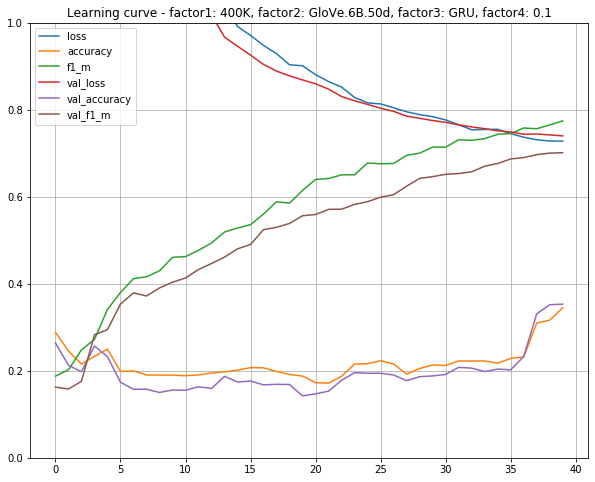

In [86]:
# Plot the learning curve
pd.DataFrame(history3.history).plot(figsize=(10, 8))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.title('Learning curve - factor1: 400K, factor2: GloVe.6B.50d, factor3: GRU, factor4: 0.1')
plt.show()

# model 3 predictions (1=disaster tweet)

In [87]:
predict3 = model3.predict_classes(X_test)
predict3

array([2, 0, 0, ..., 0, 3, 2])

In [88]:
len(predict3)

3263

In [89]:
# save the results to a csv
submission_df = pd.DataFrame({'id':test_tweets['id'],'target':np.squeeze(predict3)})
submission_df.to_csv('submission_rnn_3.csv',index=False)

In [90]:
#Store the accuracy and kaggle score for this model 
results_tbl = results_tbl.append({'Model_name':'RNN #3', 
                                   'vocabulary size (factor1)':'400K',
                                   'pre-trained vector (factor2)':'GloVe.6B.200d',
                                   'RNN structure (factor3)':'GRU layer based',
                                   'hyperparameter recurrent_dropout (factor4)': '0.1',
                                   'Processing Time':(end-start),
                                   'Training Set Accuracy':best_model_train_accuracy,
                                   'Validation Set Accuracy':best_model_val_accuracy,
                                   'train f1':best_model_train_f1,
                                   'validation f1':best_model_val_f1,
                                   'Test Set F1-score (Kaggle score)': ''
                                   },ignore_index=True)
results_tbl


,Model_name,vocabulary size (factor1),pre-trained vector (factor2),RNN structure (factor3),hyperparameter recurrent_dropout (factor4),Processing Time,Training Set Accuracy,Validation Set Accuracy,train f1,validation f1,Test Set F1-score (Kaggle score)
0,RNN #1,400K,GloVe.6B.50d,LSTM layer based,0.1,00:14:13.500154,0.3019,0.3586,0.7372,0.6869,0.78087
1,RNN #2,400K,GloVe.6B.50d,LSTM layer based,0.3,00:13:52.784631,0.7703,0.7754,0.7116,0.6222,0.78026
2,RNN #3,400K,GloVe.6B.50d,GRU layer based,0.1,00:43:38.681270,0.3447,0.3533,0.7747,0.7016,0.78302


# Fit RNN 4
# vocabulary size (factor 1): 400K
# pre-trained vector (factor 2): GloVe.6B.200d
# rnn structure (factor 3): GRU based structure
# recurrent dropout (factor 4): 0.1

In [91]:
model4 = keras.models.Sequential([
    keras.layers.Embedding(len(word2index)+1, 
                           dims, 
                           weights=[embedding_matrix],
                           input_length=maxlen,
                           trainable=False),
    keras.layers.GRU(units=128 , return_sequences = True),
    keras.layers.GRU(units=64 , recurrent_dropout = 0.1),
    keras.layers.Dense(22, activation='tanh'),
    keras.layers.Dense(4, activation='tanh')
])

In [92]:
model4.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 31, 200)           2451400   
_________________________________________________________________
gru_2 (GRU)                  (None, 31, 128)           126720    
_________________________________________________________________
gru_3 (GRU)                  (None, 64)                37248     
_________________________________________________________________
dense_14 (Dense)             (None, 22)                1430      
_________________________________________________________________
dense_15 (Dense)             (None, 4)                 92        
Total params: 2,616,890
Trainable params: 165,490
Non-trainable params: 2,451,400
_________________________________________________________________


In [93]:
opt=Adam(learning_rate=1e-5)
model4.compile(
  loss='binary_crossentropy',
  optimizer=opt,
  metrics=['accuracy', f1_m],
)

In [94]:
# Fit the model; obtain the model fit time
start=datetime.now()
history4 = model4.fit(X_train,Y_train,
                    batch_size=32,
                    epochs=40,
                    validation_split=0.3
)
end=datetime.now()
print(end-start)

Epoch 1/40
167/167 [==============================] - 12s 75ms/step - loss: 1.7254 - accuracy: 0.3218 - f1_m: 0.4054 - val_loss: 1.2994 - val_accuracy: 0.3227 - val_f1_m: 0.4045
Epoch 2/40
167/167 [==============================] - 12s 73ms/step - loss: 1.2865 - accuracy: 0.3443 - f1_m: 0.5196 - val_loss: 1.1123 - val_accuracy: 0.3870 - val_f1_m: 0.5420
Epoch 3/40
167/167 [==============================] - 12s 73ms/step - loss: 1.1078 - accuracy: 0.3755 - f1_m: 0.5977 - val_loss: 1.0096 - val_accuracy: 0.3616 - val_f1_m: 0.5609
Epoch 4/40
167/167 [==============================] - 12s 73ms/step - loss: 1.0210 - accuracy: 0.3466 - f1_m: 0.6151 - val_loss: 0.9376 - val_accuracy: 0.3323 - val_f1_m: 0.5879
Epoch 5/40
167/167 [==============================] - 12s 72ms/step - loss: 0.9469 - accuracy: 0.3323 - f1_m: 0.6444 - val_loss: 0.8866 - val_accuracy: 0.3021 - val_f1_m: 0.6106
Epoch 6/40
167/167 [==============================] - 12s 73ms/step - loss: 0.9010 - accuracy: 0.3179 - f1_m: 

In [95]:
print ('Best Train Accuracy: ')
best_model_train_accuracy = np.round(history4.history['accuracy'][np.argmin(history4.history['loss'])],4)
best_model_train_accuracy

Best Train Accuracy: 


0.2804

In [96]:
print ('Best Validation Accuracy: ')
best_model_val_accuracy = np.round(history4.history['val_accuracy'][np.argmin(history4.history['val_loss'])],4)
best_model_val_accuracy

Best Validation Accuracy: 


0.2728

In [97]:
best_model_train_f1 = max(np.round(history4.history['f1_m'],4))
print ('Best Train f1: {}'.format(best_model_train_f1))

best_model_val_f1 = max(np.round(history4.history['val_f1_m'],4))
print ('Best val f1: {}'.format(best_model_val_f1))

Best Train f1: 0.9279
Best val f1: 0.8533


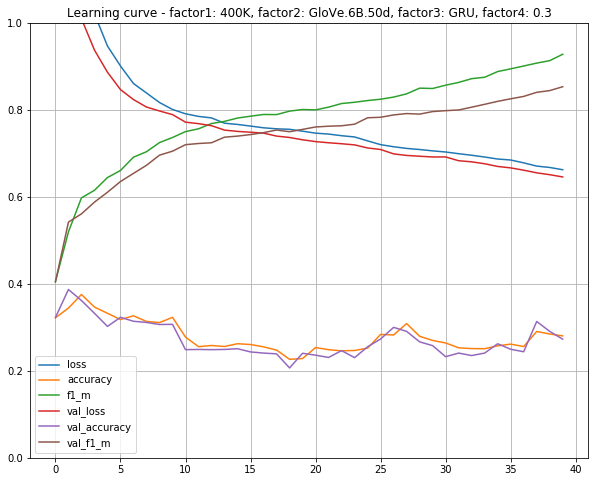

In [98]:
# Plot the learning curve
pd.DataFrame(history4.history).plot(figsize=(10, 8))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.title('Learning curve - factor1: 400K, factor2: GloVe.6B.50d, factor3: GRU, factor4: 0.3')
plt.show()


# model 4 predictions (1=disaster tweet)

In [99]:
predict4 = model4.predict_classes(X_test)
predict4


array([1, 0, 2, ..., 0, 0, 0])

In [100]:
# save the results to a csv
submission_df = pd.DataFrame({'id':test_tweets['id'],'target':np.squeeze(predict4)})
submission_df.to_csv('submission_rnn_4.csv',index=False)


In [101]:

#Store the accuracy and kaggle score for this model 
results_tbl = results_tbl.append({'Model_name':'RNN #4', 
                                   'vocabulary size (factor1)':'400K',
                                   'pre-trained vector (factor2)':'GloVe.6B.50d',
                                   'RNN structure (factor3)':'GRU layer based',
                                   'hyperparameter recurrent_dropout (factor4)': '0.3',
                                   'Processing Time':(end-start),
                                   'Training Set Accuracy':best_model_train_accuracy,
                                   'Validation Set Accuracy':best_model_val_accuracy,
                                   'train f1':best_model_train_f1,
                                   'validation f1':best_model_val_f1,
                                   'Test Set F1-score (Kaggle score)': '0.24977'
                                   },ignore_index=True)
results_tbl

,Model_name,vocabulary size (factor1),pre-trained vector (factor2),RNN structure (factor3),hyperparameter recurrent_dropout (factor4),Processing Time,Training Set Accuracy,Validation Set Accuracy,train f1,validation f1,Test Set F1-score (Kaggle score)
0,RNN #1,400K,GloVe.6B.50d,LSTM layer based,0.1,00:14:13.500154,0.3019,0.3586,0.7372,0.6869,0.78087
1,RNN #2,400K,GloVe.6B.50d,LSTM layer based,0.3,00:13:52.784631,0.7703,0.7754,0.7116,0.6222,0.78026
2,RNN #3,400K,GloVe.6B.50d,GRU layer based,0.1,00:43:38.681270,0.3447,0.3533,0.7747,0.7016,0.78302
3,RNN #4,400K,GloVe.6B.50d,GRU layer based,0.3,00:08:21.524334,0.2804,0.2728,0.9279,0.8533,0.77873


# Fit RNN 5
# vocabulary size (factor 1): 400K
# pre-trained vector (factor 2): GloVe.6B.200d
# rnn structure (factor 3): LSTM layer based structure
# recurrent dropout (factor 4): 0.1

In [102]:
model5 = keras.models.Sequential([
    keras.layers.Embedding(len(word2index)+1,200,weights=[embedding_matrix],input_length=maxlen,trainable=False),
    keras.layers.LSTM(units=128 , return_sequences = True , recurrent_dropout = 0.1 , dropout = 0.1),
    keras.layers.LSTM(units=64 , recurrent_dropout = 0.1 , dropout = 0.1),
    keras.layers.Dense(32, activation='tanh'),
    keras.layers.Dense(1, activation='tanh')
])

In [103]:
model5.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 31, 200)           2451400   
_________________________________________________________________
lstm_12 (LSTM)               (None, 31, 128)           168448    
_________________________________________________________________
lstm_13 (LSTM)               (None, 64)                49408     
_________________________________________________________________
dense_16 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 33        
Total params: 2,671,369
Trainable params: 219,969
Non-trainable params: 2,451,400
_________________________________________________________________


In [104]:
opt=Adam(learning_rate=1e-5)
model5.compile(
  loss='binary_crossentropy',
  optimizer=opt,
  metrics=['accuracy', f1_m],
)

In [105]:
# Fit the model; obtain the model fit time
start=datetime.now()
history5 = model5.fit(X_train,Y_train,
                    batch_size=32,
                    epochs=40,
                    validation_split=0.1
)
end=datetime.now()
print(end-start)

Epoch 1/40
215/215 [==============================] - 26s 119ms/step - loss: 1.7666 - accuracy: 0.5744 - f1_m: 0.0000e+00 - val_loss: 1.0577 - val_accuracy: 0.5341 - val_f1_m: 0.0000e+00
Epoch 2/40
215/215 [==============================] - 25s 115ms/step - loss: 0.8490 - accuracy: 0.5736 - f1_m: 0.0107 - val_loss: 0.8190 - val_accuracy: 0.5354 - val_f1_m: 0.0460
Epoch 3/40
215/215 [==============================] - 25s 117ms/step - loss: 0.7607 - accuracy: 0.5712 - f1_m: 0.0659 - val_loss: 0.7759 - val_accuracy: 0.5577 - val_f1_m: 0.1601
Epoch 4/40
215/215 [==============================] - 25s 116ms/step - loss: 0.7399 - accuracy: 0.5712 - f1_m: 0.1512 - val_loss: 0.7535 - val_accuracy: 0.5394 - val_f1_m: 0.2013
Epoch 5/40
215/215 [==============================] - 25s 115ms/step - loss: 0.7303 - accuracy: 0.5755 - f1_m: 0.2326 - val_loss: 0.7377 - val_accuracy: 0.5381 - val_f1_m: 0.2437
Epoch 6/40
215/215 [==============================] - 25s 114ms/step - loss: 0.7179 - accuracy: 0

In [106]:
print ('Best Train Accuracy: ')
best_model_train_accuracy = np.round(history5.history['accuracy'][np.argmin(history5.history['loss'])],4)
best_model_train_accuracy

Best Train Accuracy: 


0.7742

In [107]:
print ('Best Validation Accuracy: ')
best_model_val_accuracy = np.round(history5.history['val_accuracy'][np.argmin(history5.history['val_loss'])],4)
best_model_val_accuracy

Best Validation Accuracy: 


0.7822

In [108]:
best_model_train_f1 = max(np.round(history5.history['f1_m'],4))
print ('Best Train f1: {}'.format(best_model_train_f1))

best_model_val_f1 = max(np.round(history5.history['val_f1_m'],4))
print ('Best val f1: {}'.format(best_model_val_f1))

Best Train f1: 0.7113
Best val f1: 0.676


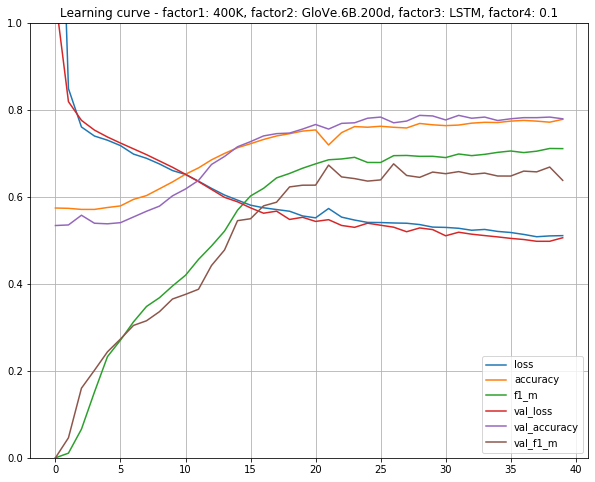

In [109]:

# Plot the learning curve
pd.DataFrame(history5.history).plot(figsize=(10, 8))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.title('Learning curve - factor1: 400K, factor2: GloVe.6B.200d, factor3: LSTM, factor4: 0.1')
plt.show()

# model 5 predictions (1=disaster tweet)

In [111]:
predict5 = model5.predict_classes(X_test)
predict5

array([[1],
       [1],
       [1],
       ...,
       [0],
       [0],
       [0]], dtype=int32)

In [112]:
len(predict5)

3263

In [113]:
# save the results to a csv
submission_df = pd.DataFrame({'id':test_tweets['id'],'target':np.squeeze(predict5)})
submission_df.to_csv('submission_rnn_5.csv',index=False)


In [114]:
#Store the accuracy and kaggle score for this model 
results_tbl = results_tbl.append({'Model_name':'RNN #5', 
                                   'vocabulary size (factor1)':'400K',
                                   'pre-trained vector (factor2)':'GloVe.6B.200d',
                                   'RNN structure (factor3)':'LSTM layer based',
                                   'hyperparameter recurrent_dropout (factor4)': '0.1',
                                   'Processing Time':(end-start),
                                   'Training Set Accuracy':best_model_train_accuracy,
                                   'Validation Set Accuracy':best_model_val_accuracy,
                                   'train f1':best_model_train_f1,
                                   'validation f1':best_model_val_f1,
                                   'Test Set F1-score (Kaggle score)': ''
                                   },ignore_index=True)
results_tbl

,Model_name,vocabulary size (factor1),pre-trained vector (factor2),RNN structure (factor3),hyperparameter recurrent_dropout (factor4),Processing Time,Training Set Accuracy,Validation Set Accuracy,train f1,validation f1,Test Set F1-score (Kaggle score)
0,RNN #1,400K,GloVe.6B.50d,LSTM layer based,0.1,00:14:13.500154,0.3019,0.3586,0.7372,0.6869,0.78087
1,RNN #2,400K,GloVe.6B.50d,LSTM layer based,0.3,00:13:52.784631,0.7703,0.7754,0.7116,0.6222,0.78026
2,RNN #3,400K,GloVe.6B.50d,GRU layer based,0.1,00:43:38.681270,0.3447,0.3533,0.7747,0.7016,0.78302
3,RNN #4,400K,GloVe.6B.50d,GRU layer based,0.3,00:08:21.524334,0.2804,0.2728,0.9279,0.8533,0.77873
4,RNN #5,400K,GloVe.6B.200d,LSTM layer based,0.1,00:21:06.903934,0.7742,0.7822,0.7113,0.6760,0.79313


# Fit RNN 6
# vocabulary size (factor 1): 400K
# pre-trained vector (factor 2): GloVe.6B.200d
# rnn structure (factor 3): LSTM layer based structure
# recurrent dropout (factor 4): 0.3


In [115]:
model6 = keras.models.Sequential([
    keras.layers.Embedding(len(word2index)+1,
                           dims,
                           weights=[embedding_matrix],
                           input_length=maxlen,
                           trainable=False),
    keras.layers.LSTM(units=128, return_sequences = True, recurrent_dropout = 0.3, dropout = 0.3),
    keras.layers.LSTM(units=64, recurrent_dropout = 0.3, dropout = 0.3),
    keras.layers.Dense(32, activation='tanh'),
    keras.layers.Dense(1, activation='tanh')
])

In [116]:
model6.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 31, 200)           2451400   
_________________________________________________________________
lstm_14 (LSTM)               (None, 31, 128)           168448    
_________________________________________________________________
lstm_15 (LSTM)               (None, 64)                49408     
_________________________________________________________________
dense_18 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 33        
Total params: 2,671,369
Trainable params: 219,969
Non-trainable params: 2,451,400
_________________________________________________________________


In [117]:
opt=Adam(learning_rate=1e-5)
model6.compile(
  loss='binary_crossentropy',
  optimizer=opt,
  metrics=['accuracy', f1_m],
)

In [118]:
# Fit the model; obtain the model fit time
start=datetime.now()
history6 = model6.fit(X_train,Y_train,
                    batch_size=32,
                    epochs=40,
                    validation_split=0.3
)
end=datetime.now()
print(end-start)

Epoch 1/40
167/167 [==============================] - 22s 134ms/step - loss: 1.7115 - accuracy: 0.5729 - f1_m: 0.0262 - val_loss: 0.9213 - val_accuracy: 0.5771 - val_f1_m: 0.1110
Epoch 2/40
167/167 [==============================] - 22s 131ms/step - loss: 0.9829 - accuracy: 0.5605 - f1_m: 0.1663 - val_loss: 0.8157 - val_accuracy: 0.5604 - val_f1_m: 0.3380
Epoch 3/40
167/167 [==============================] - 22s 131ms/step - loss: 0.8361 - accuracy: 0.5536 - f1_m: 0.2890 - val_loss: 0.7787 - val_accuracy: 0.5525 - val_f1_m: 0.3745
Epoch 4/40
167/167 [==============================] - 22s 131ms/step - loss: 0.7899 - accuracy: 0.5562 - f1_m: 0.3434 - val_loss: 0.7700 - val_accuracy: 0.5556 - val_f1_m: 0.3899
Epoch 5/40
167/167 [==============================] - 22s 131ms/step - loss: 0.8016 - accuracy: 0.5577 - f1_m: 0.3618 - val_loss: 0.7612 - val_accuracy: 0.5556 - val_f1_m: 0.4037
Epoch 6/40
167/167 [==============================] - 22s 130ms/step - loss: 0.7754 - accuracy: 0.5601 - 

In [119]:
print ('Best Train Accuracy: ')
best_model_train_accuracy = np.round(history6.history['accuracy'][np.argmin(history6.history['loss'])],4)
best_model_train_accuracy

Best Train Accuracy: 


0.6924

In [120]:
print ('Best Validation Accuracy: ')
best_model_val_accuracy = np.round(history6.history['val_accuracy'][np.argmin(history6.history['val_loss'])],4)
best_model_val_accuracy


Best Validation Accuracy: 


0.718

In [121]:
best_model_train_f1 = max(np.round(history6.history['f1_m'],4))
print ('Best Train f1: {}'.format(best_model_train_f1))

best_model_val_f1 = max(np.round(history6.history['val_f1_m'],4))
print ('Best val f1: {}'.format(best_model_val_f1))

Best Train f1: 0.569
Best val f1: 0.5129


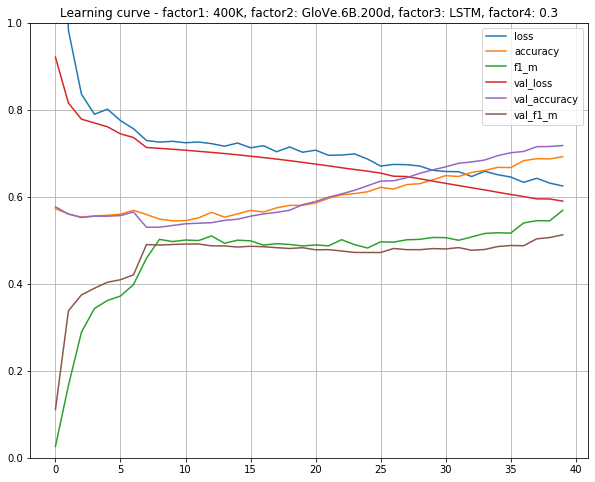

In [122]:

# Plot the learning curve
pd.DataFrame(history6.history).plot(figsize=(10, 8))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.title('Learning curve - factor1: 400K, factor2: GloVe.6B.200d, factor3: LSTM, factor4: 0.3')
plt.show()

# model 6 predictions (1=disaster tweet)

In [123]:
predict6 = model6.predict_classes(X_test)
predict6

array([[0],
       [1],
       [1],
       ...,
       [0],
       [0],
       [0]], dtype=int32)

In [124]:
len(predict6)

3263

In [125]:
# save the results to a csv
submission_df = pd.DataFrame({'id':test_tweets['id'],'target':np.squeeze(predict6)})
submission_df.to_csv('submission_rnn_6.csv',index=False)


In [126]:
#Store the accuracy and kaggle score for this model 
results_tbl = results_tbl.append({'Model_name':'RNN #6', 
                                   'vocabulary size (factor1)':'400K',
                                   'pre-trained vector (factor2)':'GloVe.6B.200d',
                                   'RNN structure (factor3)':'LSTM layer based',
                                   'hyperparameter recurrent_dropout (factor4)': '0.3',
                                   'Processing Time':(end-start),
                                   'Training Set Accuracy':best_model_train_accuracy,
                                   'Validation Set Accuracy':best_model_val_accuracy,
                                   'train f1':best_model_train_f1,
                                   'validation f1':best_model_val_f1,
                                   'Test Set F1-score (Kaggle score)': ''
                                   },ignore_index=True)
results_tbl

,Model_name,vocabulary size (factor1),pre-trained vector (factor2),RNN structure (factor3),hyperparameter recurrent_dropout (factor4),Processing Time,Training Set Accuracy,Validation Set Accuracy,train f1,validation f1,Test Set F1-score (Kaggle score)
0,RNN #1,400K,GloVe.6B.50d,LSTM layer based,0.1,00:14:13.500154,0.3019,0.3586,0.7372,0.6869,0.78087
1,RNN #2,400K,GloVe.6B.50d,LSTM layer based,0.3,00:13:52.784631,0.7703,0.7754,0.7116,0.6222,0.78026
2,RNN #3,400K,GloVe.6B.50d,GRU layer based,0.1,00:43:38.681270,0.3447,0.3533,0.7747,0.7016,0.78302
3,RNN #4,400K,GloVe.6B.50d,GRU layer based,0.3,00:08:21.524334,0.2804,0.2728,0.9279,0.8533,0.77873
4,RNN #5,400K,GloVe.6B.200d,LSTM layer based,0.1,00:21:06.903934,0.7742,0.7822,0.7113,0.6760,0.79313
5,RNN #6,400K,GloVe.6B.200d,LSTM layer based,0.3,00:14:37.386485,0.6924,0.7180,0.5690,0.5129,0.78639


# Fit RNN 7
# vocabulary size (factor 1): 400K
# pre-trained vector (factor 2): GloVe.6B.200d
# rnn structure (factor 3): GRU layer based structure
# recurrent dropout (factor 4): 0.1


In [127]:

model7 = keras.models.Sequential([
    keras.layers.Embedding(len(word2index)+1,200,weights=[embedding_matrix],input_length=maxlen,trainable=False),
    keras.layers.GRU(units=128 , return_sequences = True , recurrent_dropout = 0.1 , dropout = 0.1),
    keras.layers.GRU(units=64 , recurrent_dropout = 0.1 , dropout = 0.1),
    keras.layers.Dense(32, activation='tanh'),
    keras.layers.Dense(1, activation='sigmoid')
])

In [128]:
model7.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 31, 200)           2451400   
_________________________________________________________________
gru_4 (GRU)                  (None, 31, 128)           126720    
_________________________________________________________________
gru_5 (GRU)                  (None, 64)                37248     
_________________________________________________________________
dense_20 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 33        
Total params: 2,617,481
Trainable params: 166,081
Non-trainable params: 2,451,400
_________________________________________________________________


In [129]:
opt=Adam(learning_rate=1e-5)
model7.compile(
  loss='binary_crossentropy',
  optimizer=opt,
  metrics=['accuracy', f1_m],
)

In [130]:
# Fit the model; obtain the model fit time
start=datetime.now()
history7 = model7.fit(X_train,Y_train,
                    batch_size=32,
                    epochs=40,
                    validation_split=0.3
)
end=datetime.now()
print(end-start)



Epoch 1/40
167/167 [==============================] - 23s 135ms/step - loss: 0.6606 - accuracy: 0.6320 - f1_m: 0.3954 - val_loss: 0.6459 - val_accuracy: 0.6576 - val_f1_m: 0.3074
Epoch 2/40
167/167 [==============================] - 22s 132ms/step - loss: 0.6366 - accuracy: 0.6705 - f1_m: 0.4418 - val_loss: 0.6213 - val_accuracy: 0.6996 - val_f1_m: 0.3875
Epoch 3/40
167/167 [==============================] - 23s 138ms/step - loss: 0.6143 - accuracy: 0.7020 - f1_m: 0.5345 - val_loss: 0.5954 - val_accuracy: 0.7307 - val_f1_m: 0.4636
Epoch 4/40
167/167 [==============================] - 23s 139ms/step - loss: 0.5904 - accuracy: 0.7326 - f1_m: 0.6150 - val_loss: 0.5699 - val_accuracy: 0.7443 - val_f1_m: 0.5064
Epoch 5/40
167/167 [==============================] - 24s 141ms/step - loss: 0.5682 - accuracy: 0.7442 - f1_m: 0.6528 - val_loss: 0.5454 - val_accuracy: 0.7592 - val_f1_m: 0.5493
Epoch 6/40
167/167 [==============================] - 24s 145ms/step - loss: 0.5471 - accuracy: 0.7559 - 

In [131]:
print ('Best Train Accuracy: ')
best_model_train_accuracy = np.round(history7.history['accuracy'][np.argmin(history7.history['loss'])],4)
best_model_train_accuracy


Best Train Accuracy: 


0.8122

In [132]:
print ('Best Validation Accuracy: ')
best_model_val_accuracy = np.round(history7.history['val_accuracy'][np.argmin(history7.history['val_loss'])],4)
best_model_val_accuracy

Best Validation Accuracy: 


0.8039

In [133]:
best_model_train_f1 = max(np.round(history7.history['f1_m'],4))
print ('Best Train f1: {}'.format(best_model_train_f1))

best_model_val_f1 = max(np.round(history7.history['val_f1_m'],4))
print ('Best val f1: {}'.format(best_model_val_f1))

Best Train f1: 0.7565
Best val f1: 0.6341


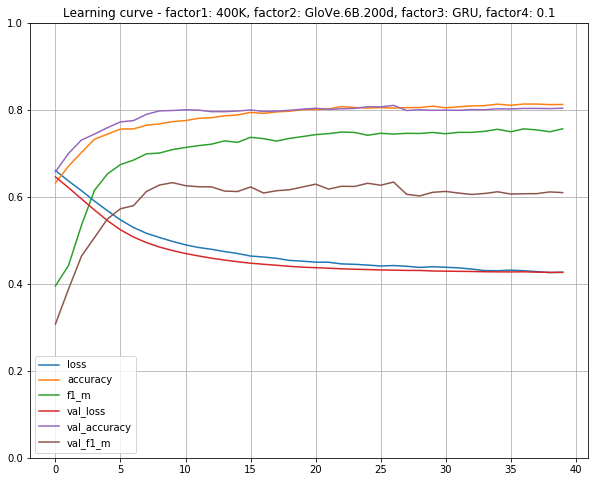

In [134]:
# Plot the learning curve
pd.DataFrame(history7.history).plot(figsize=(10, 8))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.title('Learning curve - factor1: 400K, factor2: GloVe.6B.200d, factor3: GRU, factor4: 0.1')
plt.show()


# model 7 predictions (1=disaster tweet)

In [135]:
predict7 = model7.predict_classes(X_test)
predict7

array([[1],
       [1],
       [1],
       ...,
       [1],
       [1],
       [0]], dtype=int32)

In [136]:
len(predict7)

3263

In [137]:
# save the results to a csv
submission_df = pd.DataFrame({'id':test_tweets['id'],'target':np.squeeze(predict7)})
submission_df.to_csv('submission_rnn_7.csv',index=False)

In [138]:
#Store the accuracy and kaggle score for this model 
results_tbl = results_tbl.append({'Model_name':'RNN #7', 
                                   'vocabulary size (factor1)':'400K',
                                   'pre-trained vector (factor2)':'GloVe.6B.200d',
                                   'RNN structure (factor3)':'GRU layer based',
                                   'hyperparameter recurrent_dropout (factor4)': '0.1',
                                   'Processing Time':(end-start),
                                   'Training Set Accuracy':best_model_train_accuracy,
                                   'Validation Set Accuracy':best_model_val_accuracy,
                                   'train f1':best_model_train_f1,
                                   'validation f1':best_model_val_f1,
                                   'Test Set F1-score (Kaggle score)': ''
                                   },ignore_index=True)
results_tbl


,Model_name,vocabulary size (factor1),pre-trained vector (factor2),RNN structure (factor3),hyperparameter recurrent_dropout (factor4),Processing Time,Training Set Accuracy,Validation Set Accuracy,train f1,validation f1,Test Set F1-score (Kaggle score)
0,RNN #1,400K,GloVe.6B.50d,LSTM layer based,0.1,00:14:13.500154,0.3019,0.3586,0.7372,0.6869,0.78087
1,RNN #2,400K,GloVe.6B.50d,LSTM layer based,0.3,00:13:52.784631,0.7703,0.7754,0.7116,0.6222,0.78026
2,RNN #3,400K,GloVe.6B.50d,GRU layer based,0.1,00:43:38.681270,0.3447,0.3533,0.7747,0.7016,0.78302
3,RNN #4,400K,GloVe.6B.50d,GRU layer based,0.3,00:08:21.524334,0.2804,0.2728,0.9279,0.8533,0.77873
4,RNN #5,400K,GloVe.6B.200d,LSTM layer based,0.1,00:21:06.903934,0.7742,0.7822,0.7113,0.6760,0.79313
5,RNN #6,400K,GloVe.6B.200d,LSTM layer based,0.3,00:14:37.386485,0.6924,0.7180,0.5690,0.5129,0.78639
6,RNN #7,400K,GloVe.6B.200d,GRU layer based,0.1,00:14:44.563094,0.8122,0.8039,0.7565,0.6341,0.79068


# Fit RNN 8
# vocabulary size (factor 1): 400K
# pre-trained vector (factor 2): GloVe.6B.200d
# rnn structure (factor 3): GRU based structure
# recurrent dropout (factor 4): 0.3

In [139]:
model8 = keras.models.Sequential([
    keras.layers.Embedding(len(word2index)+1,200,weights=[embedding_matrix],input_length=maxlen,trainable=False),
    keras.layers.GRU(units=128 , return_sequences = True , recurrent_dropout = 0.3 , dropout = 0.3),
    keras.layers.GRU(units=64 , recurrent_dropout = 0.3 , dropout = 0.3),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])


In [140]:
model8.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 31, 200)           2451400   
_________________________________________________________________
gru_6 (GRU)                  (None, 31, 128)           126720    
_________________________________________________________________
gru_7 (GRU)                  (None, 64)                37248     
_________________________________________________________________
dense_22 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 33        
Total params: 2,617,481
Trainable params: 166,081
Non-trainable params: 2,451,400
_________________________________________________________________


In [141]:
opt=Adam(learning_rate=1e-5)
model8.compile(
  loss='binary_crossentropy',
  optimizer=opt,
  metrics=['accuracy', f1_m],
)


In [142]:
# Fit the model; obtain the model fit time
start=datetime.now()
history8 = model8.fit(X_train,Y_train,
                    batch_size=32,
                    epochs=40,
                    validation_split=0.3
)
end=datetime.now()
print(end-start)

Epoch 1/40
167/167 [==============================] - 22s 129ms/step - loss: 0.7002 - accuracy: 0.5055 - f1_m: 0.3008 - val_loss: 0.6898 - val_accuracy: 0.5504 - val_f1_m: 0.1559
Epoch 2/40
167/167 [==============================] - 23s 139ms/step - loss: 0.6794 - accuracy: 0.5757 - f1_m: 0.3002 - val_loss: 0.6704 - val_accuracy: 0.5841 - val_f1_m: 0.1847
Epoch 3/40
167/167 [==============================] - 26s 153ms/step - loss: 0.6638 - accuracy: 0.6080 - f1_m: 0.3408 - val_loss: 0.6506 - val_accuracy: 0.6414 - val_f1_m: 0.2922
Epoch 4/40
167/167 [==============================] - 25s 148ms/step - loss: 0.6470 - accuracy: 0.6495 - f1_m: 0.4451 - val_loss: 0.6302 - val_accuracy: 0.6791 - val_f1_m: 0.3804
Epoch 5/40
167/167 [==============================] - 24s 145ms/step - loss: 0.6310 - accuracy: 0.6767 - f1_m: 0.5259 - val_loss: 0.6095 - val_accuracy: 0.7180 - val_f1_m: 0.4581
Epoch 6/40
167/167 [==============================] - 31s 188ms/step - loss: 0.6146 - accuracy: 0.6986 - 

In [143]:
print ('Best Train Accuracy: ')
best_model_train_accuracy = np.round(history8.history['accuracy'][np.argmin(history8.history['loss'])],4)
best_model_train_accuracy

Best Train Accuracy: 


0.7962

In [144]:
print ('Best Validation Accuracy: ')
best_model_val_accuracy = np.round(history8.history['val_accuracy'][np.argmin(history8.history['val_loss'])],4)
best_model_val_accuracy

Best Validation Accuracy: 


0.792

In [145]:
best_model_train_f1 = max(np.round(history8.history['f1_m'],4))
print ('Best Train f1: {}'.format(best_model_train_f1))

best_model_val_f1 = max(np.round(history8.history['val_f1_m'],4))
print ('Best val f1: {}'.format(best_model_val_f1))

Best Train f1: 0.738
Best val f1: 0.62


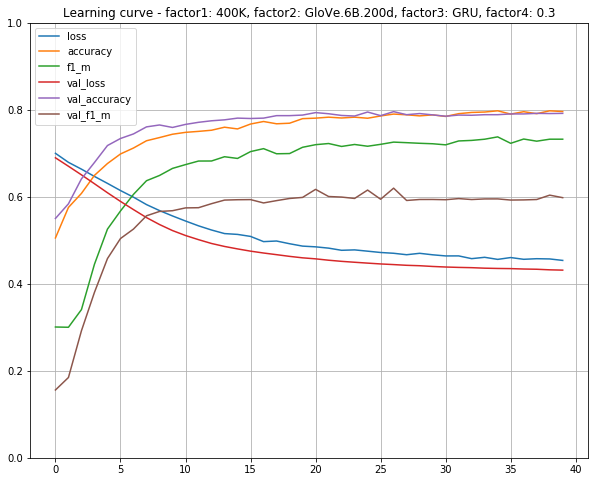

In [146]:
# Plot the learning curve
pd.DataFrame(history8.history).plot(figsize=(10, 8))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.title('Learning curve - factor1: 400K, factor2: GloVe.6B.200d, factor3: GRU, factor4: 0.3')
plt.show()

# model 8 predictions (1=disaster tweet)

In [147]:
predict8 = model8.predict_classes(X_test)
predict8


array([[1],
       [1],
       [1],
       ...,
       [1],
       [1],
       [0]], dtype=int32)

In [148]:
# save the results to a csv
submission_df = pd.DataFrame({'id':test_tweets['id'],'target':np.squeeze(predict8)})
submission_df.to_csv('submission_rnn_8.csv',index=False)


In [149]:
#Store the accuracy and kaggle score for this model 
results_tbl = results_tbl.append({'Model_name':'RNN #8', 
                                   'vocabulary size (factor1)':'400K',
                                   'pre-trained vector (factor2)':'GloVe.6B.200d',
                                   'RNN structure (factor3)':'GRU layer based',
                                   'hyperparameter recurrent_dropout (factor4)': '0.3',
                                   'Processing Time':(end-start),
                                   'Training Set Accuracy':best_model_train_accuracy,
                                   'Validation Set Accuracy':best_model_val_accuracy,
                                   'train f1':best_model_train_f1,
                                   'validation f1':best_model_val_f1,
                                   'Test Set F1-score (Kaggle score)': ''
                                   },ignore_index=True)
results_tbl

,Model_name,vocabulary size (factor1),pre-trained vector (factor2),RNN structure (factor3),hyperparameter recurrent_dropout (factor4),Processing Time,Training Set Accuracy,Validation Set Accuracy,train f1,validation f1,Test Set F1-score (Kaggle score)
0,RNN #1,400K,GloVe.6B.50d,LSTM layer based,0.1,00:14:13.500154,0.3019,0.3586,0.7372,0.6869,0.78087
1,RNN #2,400K,GloVe.6B.50d,LSTM layer based,0.3,00:13:52.784631,0.7703,0.7754,0.7116,0.6222,0.78026
2,RNN #3,400K,GloVe.6B.50d,GRU layer based,0.1,00:43:38.681270,0.3447,0.3533,0.7747,0.7016,0.78302
3,RNN #4,400K,GloVe.6B.50d,GRU layer based,0.3,00:08:21.524334,0.2804,0.2728,0.9279,0.8533,0.77873
4,RNN #5,400K,GloVe.6B.200d,LSTM layer based,0.1,00:21:06.903934,0.7742,0.7822,0.7113,0.6760,0.79313
5,RNN #6,400K,GloVe.6B.200d,LSTM layer based,0.3,00:14:37.386485,0.6924,0.7180,0.5690,0.5129,0.78639
6,RNN #7,400K,GloVe.6B.200d,GRU layer based,0.1,00:14:44.563094,0.8122,0.8039,0.7565,0.6341,0.79068
7,RNN #8,400K,GloVe.6B.200d,GRU layer based,0.3,00:19:17.637735,0.7962,0.7920,0.7380,0.6200,0.78608


# Fit RNN 9
# vocabulary size (factor 1): 400K
# pre-trained vector (factor 2): GloVe.6B.200d
# rnn structure (factor 3): GRU based structure
# recurrent dropout (factor 4): 0.3

In [150]:
model9 = keras.models.Sequential([
    keras.layers.Embedding(len(word2index)+1,
                           dims,
                           weights=[embedding_matrix],
                           input_length=maxlen,
                           trainable=False),
    keras.layers.GRU(units=128, return_sequences = True, recurrent_dropout = 0.3, dropout = 0.3),
    keras.layers.GRU(units=64, recurrent_dropout = 0.3, dropout = 0.3),
    keras.layers.Dense(32, activation='tanh'),
    keras.layers.Dense(1, activation='sigmoid')
])

In [151]:
model9.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 31, 200)           2451400   
_________________________________________________________________
gru_8 (GRU)                  (None, 31, 128)           126720    
_________________________________________________________________
gru_9 (GRU)                  (None, 64)                37248     
_________________________________________________________________
dense_24 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 33        
Total params: 2,617,481
Trainable params: 166,081
Non-trainable params: 2,451,400
_________________________________________________________________


In [152]:
opt=Adam(learning_rate=1e-5)
model9.compile(
  loss='binary_crossentropy',
  optimizer=opt,
  metrics=['accuracy', f1_m],
)

In [153]:
# Fit the model; obtain the model fit time
start=datetime.now()
history9 = model9.fit(X_train,Y_train,
                    batch_size=32,
                    epochs=40,
                    validation_split=0.3
)
end=datetime.now()
print(end-start)

Epoch 1/40
167/167 [==============================] - 21s 124ms/step - loss: 0.6873 - accuracy: 0.5491 - f1_m: 0.4258 - val_loss: 0.6650 - val_accuracy: 0.6322 - val_f1_m: 0.2998
Epoch 2/40
167/167 [==============================] - 20s 119ms/step - loss: 0.6603 - accuracy: 0.6239 - f1_m: 0.3938 - val_loss: 0.6447 - val_accuracy: 0.6537 - val_f1_m: 0.3116
Epoch 3/40
167/167 [==============================] - 22s 129ms/step - loss: 0.6447 - accuracy: 0.6470 - f1_m: 0.4281 - val_loss: 0.6239 - val_accuracy: 0.6970 - val_f1_m: 0.4044
Epoch 4/40
167/167 [==============================] - 21s 123ms/step - loss: 0.6275 - accuracy: 0.6791 - f1_m: 0.5170 - val_loss: 0.6036 - val_accuracy: 0.7189 - val_f1_m: 0.4660
Epoch 5/40
167/167 [==============================] - 24s 143ms/step - loss: 0.6095 - accuracy: 0.6988 - f1_m: 0.5648 - val_loss: 0.5828 - val_accuracy: 0.7452 - val_f1_m: 0.5202
Epoch 6/40
167/167 [==============================] - 21s 124ms/step - loss: 0.5927 - accuracy: 0.7095 - 

In [154]:
print ('Best Train Accuracy: ')
best_model_train_accuracy = np.round(history9.history['accuracy'][np.argmin(history9.history['loss'])],4)
best_model_train_accuracy

Best Train Accuracy: 


0.7919

In [155]:
print ('Best Validation Accuracy: ')
best_model_val_accuracy = np.round(history9.history['val_accuracy'][np.argmin(history9.history['val_loss'])],4)
best_model_val_accuracy

Best Validation Accuracy: 


0.7942

In [156]:
best_model_train_f1 = max(np.round(history9.history['f1_m'],4))
print ('Best Train f1: {}'.format(best_model_train_f1))

Best Train f1: 0.7351


In [157]:
best_model_val_f1 = max(np.round(history9.history['val_f1_m'],4))
print ('Best val f1: {}'.format(best_model_val_f1))

Best val f1: 0.603


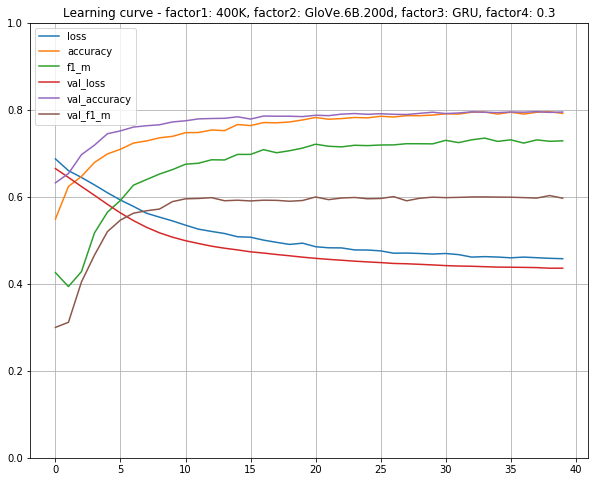

In [158]:
# Plot the learning curve
pd.DataFrame(history9.history).plot(figsize=(10, 8))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.title('Learning curve - factor1: 400K, factor2: GloVe.6B.200d, factor3: GRU, factor4: 0.3')
plt.show()

# model 9 predictions (1=disaster tweet)

In [159]:
predict9 = model9.predict_classes(X_test)
predict9

array([[1],
       [1],
       [1],
       ...,
       [1],
       [0],
       [0]], dtype=int32)

In [160]:
# save the results to a csv
submission_df = pd.DataFrame({'id':test_tweets['id'],'target':np.squeeze(predict9)})
submission_df.to_csv('submission_rnn_9.csv',index=False)

In [161]:
#Store the accuracy and kaggle score for this model 
results_tbl = results_tbl.append({'Model_name':'RNN #9', 
                                   'vocabulary size (factor1)':'400K',
                                   'pre-trained vector (factor2)':'GloVe.6B.200d',
                                   'RNN structure (factor3)':'GRU layer based',
                                   'hyperparameter recurrent_dropout (factor4)': '0.3',
                                   'Processing Time':(end-start),
                                   'Training Set Accuracy':best_model_train_accuracy,
                                   'Validation Set Accuracy':best_model_val_accuracy,
                                   'train f1':best_model_train_f1,
                                   'validation f1':best_model_val_f1,
                                   'Test Set F1-score (Kaggle score)': ''
                                   },ignore_index=True)
results_tbl

,Model_name,vocabulary size (factor1),pre-trained vector (factor2),RNN structure (factor3),hyperparameter recurrent_dropout (factor4),Processing Time,Training Set Accuracy,Validation Set Accuracy,train f1,validation f1,Test Set F1-score (Kaggle score)
0,RNN #1,400K,GloVe.6B.50d,LSTM layer based,0.1,00:14:13.500154,0.3019,0.3586,0.7372,0.6869,0.78087
1,RNN #2,400K,GloVe.6B.50d,LSTM layer based,0.3,00:13:52.784631,0.7703,0.7754,0.7116,0.6222,0.78026
2,RNN #3,400K,GloVe.6B.50d,GRU layer based,0.1,00:43:38.681270,0.3447,0.3533,0.7747,0.7016,0.78302
3,RNN #4,400K,GloVe.6B.50d,GRU layer based,0.3,00:08:21.524334,0.2804,0.2728,0.9279,0.8533,0.77873
4,RNN #5,400K,GloVe.6B.200d,LSTM layer based,0.1,00:21:06.903934,0.7742,0.7822,0.7113,0.6760,0.79313
5,RNN #6,400K,GloVe.6B.200d,LSTM layer based,0.3,00:14:37.386485,0.6924,0.7180,0.5690,0.5129,0.78639
6,RNN #7,400K,GloVe.6B.200d,GRU layer based,0.1,00:14:44.563094,0.8122,0.8039,0.7565,0.6341,0.79068
7,RNN #8,400K,GloVe.6B.200d,GRU layer based,0.3,00:19:17.637735,0.7962,0.7920,0.7380,0.6200,0.78608
8,RNN #9,400K,GloVe.6B.200d,GRU layer based,0.3,00:14:53.940924,0.7919,0.7942,0.7351,0.6030,


In [162]:
# cleaning table bc I changed stuff and this takes way too long to run
results_tbl.loc[:,['Test Set F1-score (Kaggle score)']] = np.nan
results_tbl.loc[:,['pre-trained vector (factor2)']] = "GloVe.6B.200d"

In [163]:
results_tbl

,Model_name,vocabulary size (factor1),pre-trained vector (factor2),RNN structure (factor3),hyperparameter recurrent_dropout (factor4),Processing Time,Training Set Accuracy,Validation Set Accuracy,train f1,validation f1,Test Set F1-score (Kaggle score)
0,RNN #1,400K,GloVe.6B.200d,LSTM layer based,0.1,00:14:13.500154,0.3019,0.3586,0.7372,0.6869,NaN
1,RNN #2,400K,GloVe.6B.200d,LSTM layer based,0.3,00:13:52.784631,0.7703,0.7754,0.7116,0.6222,NaN
2,RNN #3,400K,GloVe.6B.200d,GRU layer based,0.1,00:43:38.681270,0.3447,0.3533,0.7747,0.7016,NaN
3,RNN #4,400K,GloVe.6B.200d,GRU layer based,0.3,00:08:21.524334,0.2804,0.2728,0.9279,0.8533,NaN
4,RNN #5,400K,GloVe.6B.200d,LSTM layer based,0.1,00:21:06.903934,0.7742,0.7822,0.7113,0.6760,NaN
5,RNN #6,400K,GloVe.6B.200d,LSTM layer based,0.3,00:14:37.386485,0.6924,0.7180,0.5690,0.5129,NaN
6,RNN #7,400K,GloVe.6B.200d,GRU layer based,0.1,00:14:44.563094,0.8122,0.8039,0.7565,0.6341,NaN
7,RNN #8,400K,GloVe.6B.200d,GRU layer based,0.3,00:19:17.637735,0.7962,0.7920,0.7380,0.6200,NaN
8,RNN #9,400K,GloVe.6B.200d,GRU layer based,0.3,00:14:53.940924,0.7919,0.7942,0.7351,0.6030,NaN


In [164]:
# things I submitted to Kaggle.. https://www.kaggle.com/c/nlp-getting-started/ w/ kbridge14
results_tbl.loc[results_tbl['Model_name']=="RNN #4",['Test Set F1-score (Kaggle score)']] = "0.24977"
results_tbl.loc[results_tbl['Model_name']=="RNN #7",['Test Set F1-score (Kaggle score)']] = "0.79007"

In [165]:
results_tbl

,Model_name,vocabulary size (factor1),pre-trained vector (factor2),RNN structure (factor3),hyperparameter recurrent_dropout (factor4),Processing Time,Training Set Accuracy,Validation Set Accuracy,train f1,validation f1,Test Set F1-score (Kaggle score)
0,RNN #1,400K,GloVe.6B.200d,LSTM layer based,0.1,00:14:13.500154,0.3019,0.3586,0.7372,0.6869,NaN
1,RNN #2,400K,GloVe.6B.200d,LSTM layer based,0.3,00:13:52.784631,0.7703,0.7754,0.7116,0.6222,NaN
2,RNN #3,400K,GloVe.6B.200d,GRU layer based,0.1,00:43:38.681270,0.3447,0.3533,0.7747,0.7016,NaN
3,RNN #4,400K,GloVe.6B.200d,GRU layer based,0.3,00:08:21.524334,0.2804,0.2728,0.9279,0.8533,0.24977
4,RNN #5,400K,GloVe.6B.200d,LSTM layer based,0.1,00:21:06.903934,0.7742,0.7822,0.7113,0.6760,NaN
5,RNN #6,400K,GloVe.6B.200d,LSTM layer based,0.3,00:14:37.386485,0.6924,0.7180,0.5690,0.5129,NaN
6,RNN #7,400K,GloVe.6B.200d,GRU layer based,0.1,00:14:44.563094,0.8122,0.8039,0.7565,0.6341,0.79007
7,RNN #8,400K,GloVe.6B.200d,GRU layer based,0.3,00:19:17.637735,0.7962,0.7920,0.7380,0.6200,NaN
8,RNN #9,400K,GloVe.6B.200d,GRU layer based,0.3,00:14:53.940924,0.7919,0.7942,0.7351,0.6030,NaN


In [166]:
# model 9 was a huge disappointment but it's ok
results_tbl.loc[results_tbl['Model_name']=="RNN #3",['Test Set F1-score (Kaggle score)']] = "0.36040" #sad
results_tbl.loc[results_tbl['Model_name']=="RNN #8",['Test Set F1-score (Kaggle score)']] = "0.78516"

In [167]:
results_tbl

,Model_name,vocabulary size (factor1),pre-trained vector (factor2),RNN structure (factor3),hyperparameter recurrent_dropout (factor4),Processing Time,Training Set Accuracy,Validation Set Accuracy,train f1,validation f1,Test Set F1-score (Kaggle score)
0,RNN #1,400K,GloVe.6B.200d,LSTM layer based,0.1,00:14:13.500154,0.3019,0.3586,0.7372,0.6869,NaN
1,RNN #2,400K,GloVe.6B.200d,LSTM layer based,0.3,00:13:52.784631,0.7703,0.7754,0.7116,0.6222,NaN
2,RNN #3,400K,GloVe.6B.200d,GRU layer based,0.1,00:43:38.681270,0.3447,0.3533,0.7747,0.7016,0.36040
3,RNN #4,400K,GloVe.6B.200d,GRU layer based,0.3,00:08:21.524334,0.2804,0.2728,0.9279,0.8533,0.24977
4,RNN #5,400K,GloVe.6B.200d,LSTM layer based,0.1,00:21:06.903934,0.7742,0.7822,0.7113,0.6760,NaN
5,RNN #6,400K,GloVe.6B.200d,LSTM layer based,0.3,00:14:37.386485,0.6924,0.7180,0.5690,0.5129,NaN
6,RNN #7,400K,GloVe.6B.200d,GRU layer based,0.1,00:14:44.563094,0.8122,0.8039,0.7565,0.6341,0.79007
7,RNN #8,400K,GloVe.6B.200d,GRU layer based,0.3,00:19:17.637735,0.7962,0.7920,0.7380,0.6200,0.78516
8,RNN #9,400K,GloVe.6B.200d,GRU layer based,0.3,00:14:53.940924,0.7919,0.7942,0.7351,0.6030,NaN
